## Exploratory Data Analysis

### Overview and Setup
In this section, we perform exploratory data analysis (EDA) on a dataset comprising weather and population data from ten major U.S. cities. The goal is to explore the relationship between urban population growth and various weather-related variables over the past 50 years.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm

### Data Sources and Structure
The data for this analysis is sourced from the National Centers for Environmental Information (NCEI), each containing monthly weather data for the cities of interest. In addition to weather data, we also have a separate dataset containing annual population figures for these cities from 1970 to 2023. These datasets are loaded and combined into a single DataFrame, which serves as the primary dataset for our analysis.


In [2]:
# List of city names and states
cities = ['New York', 'Jacksonville', 'Dallas', 'San Antonio', 'San Diego', 'Houston', 'Phoenix', 'Philadelphia', 'Los Angeles', 'Seattle']
states = ['NY', 'FL', 'TX', 'TX', 'CA', 'TX', 'AZ', 'PA', 'CA', 'WA']

In [3]:
# List of data files
data_files = [
    '/Users/rileychisholm/Downloads/Weather(NY).csv',
    '/Users/rileychisholm/Downloads/Weather(Jax).csv',
    '/Users/rileychisholm/Downloads/Weather(Dallas).csv',
    '/Users/rileychisholm/Downloads/Weather(SA).csv',
    '/Users/rileychisholm/Downloads/Weather(SD).csv',
    '/Users/rileychisholm/Downloads/Weather(Houston).csv',
    '/Users/rileychisholm/Downloads/Weather(Phoenix).csv',
    '/Users/rileychisholm/Downloads/Weather(Philly).csv',
    '/Users/rileychisholm/Downloads/Weather(LA).csv',
    '/Users/rileychisholm/Downloads/Weather(Seattle).csv'
]

In [5]:
# Load the population data
pop = pd.read_csv('/Users/rileychisholm/Downloads/population_data.csv')

In [6]:
pop

,Year,City,Population
0,1970,New York,7894862.0
1,1971,New York,7812539.7
2,1972,New York,7730217.4
3,1973,New York,7647895.1
4,1974,New York,7565572.8
...,...,...,...
535,2019,Jacksonville,936828.3
536,2020,Jacksonville,949611.0
537,2021,Jacksonville,949611.0
538,2022,Jacksonville,949611.0


In [7]:
# Load and process each dataset
dfs = []
for city, state, file in zip(cities, states, data_files):
    df = pd.read_csv(file)
    df['City'] = city
    df['State'] = state
    dfs.append(df)

In [8]:
# Combine all datasets into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

In [9]:
# Extract the year from the 'DATE' column in combined_df
combined_df['Year'] = pd.to_datetime(combined_df['DATE']).dt.year

In [10]:
# Merge population data with combined_df
combined_df = pd.merge(combined_df, pop, how='left', on=['Year', 'City'])

### Data Overview
The combined dataset comprises 17 columns and contains over 6,000 entries. After merging, we check for and handle any missing values. Specifically, any 'unknown' values in the numerical columns are replaced with `NaN`, and these are subsequently filled with the mean value of the respective columns. This ensures that our dataset is complete and ready for analysis. Additionally, we convert the `DATE` column to a datetime format to facilitate time-series analysis.


In [11]:
combined_df

,STATION,DATE,AWND,EMNT,EMXT,PRCP,RHAV,RHMN,RHMX,SNOW,TAVG,TMAX,TMIN,City,State,Year,Population
0,USW00094728,1974-01,NaN,6.0,66.0,3.81,NaN,NaN,NaN,7.8,35.2,41.3,29.0,New York,NY,1974,7565572.8
1,USW00094728,1974-02,NaN,11.0,62.0,1.49,NaN,NaN,NaN,9.4,31.7,38.7,24.7,New York,NY,1974,7565572.8
2,USW00094728,1974-03,NaN,20.0,70.0,5.76,NaN,NaN,NaN,3.2,42.0,50.1,34.0,New York,NY,1974,7565572.8
3,USW00094728,1974-04,NaN,28.0,89.0,3.83,NaN,NaN,NaN,0.3,55.1,65.0,45.3,New York,NY,1974,7565572.8
4,USW00094728,1974-05,NaN,40.0,92.0,4.30,NaN,NaN,NaN,0.0,60.9,69.4,52.4,New York,NY,1974,7565572.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6004,USW00024233,2023-09,6.9,46.0,87.0,3.44,68.0,48.0,88.0,0.0,62.0,70.6,53.4,Seattle,WA,2023,737015.0
6005,USW00024233,2023-10,6.7,32.0,79.0,2.89,77.0,57.0,92.0,0.0,54.6,61.4,47.8,Seattle,WA,2023,737015.0
6006,USW00024233,2023-11,6.7,28.0,63.0,5.79,79.0,63.0,93.0,0.0,44.9,51.0,38.7,Seattle,WA,2023,737015.0
6007,USW00024233,2023-12,7.2,30.0,63.0,8.48,NaN,NaN,NaN,0.0,45.5,50.6,40.4,Seattle,WA,2023,737015.0


In [12]:
# Handle missing values by replacing 'unknown' in numerical columns with NaN
combined_df.replace('unknown', np.nan, inplace=True)

In [13]:
# Convert the DATE column to datetime format
combined_df['DATE'] = pd.to_datetime(combined_df['DATE'], format='%Y-%m')

In [14]:
# Convert numeric columns to appropriate dtype
numeric_columns = ['AWND', 'EMNT', 'EMXT', 'PRCP', 'RHAV', 'RHMN', 'RHMX', 'SNOW', 'TAVG', 'TMAX', 'TMIN']
for col in numeric_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

In [15]:
# Fill remaining NaN values with the mean of the column
for col in numeric_columns:
    combined_df[col].fillna(combined_df[col].mean(), inplace=True)

In [16]:
# Check for any NaN values after merging
print(combined_df.isnull().sum())

STATION        0
DATE           0
AWND           0
EMNT           0
EMXT           0
PRCP           0
RHAV           0
RHMN           0
RHMX           0
SNOW           0
TAVG           0
TMAX           0
TMIN           0
City           0
State          0
Year           0
Population    10
dtype: int64


In [17]:
# Drop any remaining NaN rows
combined_df.dropna(inplace=True)

In [18]:
combined_df

,STATION,DATE,AWND,EMNT,EMXT,PRCP,RHAV,RHMN,RHMX,SNOW,TAVG,TMAX,TMIN,City,State,Year,Population
0,USW00094728,1974-01-01,7.071176,6.0,66.0,3.81,62.407581,43.113711,81.423491,7.8,35.2,41.3,29.0,New York,NY,1974,7565572.8
1,USW00094728,1974-02-01,7.071176,11.0,62.0,1.49,62.407581,43.113711,81.423491,9.4,31.7,38.7,24.7,New York,NY,1974,7565572.8
2,USW00094728,1974-03-01,7.071176,20.0,70.0,5.76,62.407581,43.113711,81.423491,3.2,42.0,50.1,34.0,New York,NY,1974,7565572.8
3,USW00094728,1974-04-01,7.071176,28.0,89.0,3.83,62.407581,43.113711,81.423491,0.3,55.1,65.0,45.3,New York,NY,1974,7565572.8
4,USW00094728,1974-05-01,7.071176,40.0,92.0,4.30,62.407581,43.113711,81.423491,0.0,60.9,69.4,52.4,New York,NY,1974,7565572.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,USW00024233,2023-08-01,7.200000,52.0,95.0,0.27,60.000000,41.000000,81.000000,0.0,69.9,79.9,59.9,Seattle,WA,2023,737015.0
6004,USW00024233,2023-09-01,6.900000,46.0,87.0,3.44,68.000000,48.000000,88.000000,0.0,62.0,70.6,53.4,Seattle,WA,2023,737015.0
6005,USW00024233,2023-10-01,6.700000,32.0,79.0,2.89,77.000000,57.000000,92.000000,0.0,54.6,61.4,47.8,Seattle,WA,2023,737015.0
6006,USW00024233,2023-11-01,6.700000,28.0,63.0,5.79,79.000000,63.000000,93.000000,0.0,44.9,51.0,38.7,Seattle,WA,2023,737015.0


In [19]:
# Saves the combined dataset to a new CSV file
# combined_df.to_csv('/Users/rileychisholm/Downloads/Combined_Weather_Data.csv', index=False)

In [20]:
# Display dataset information and summary statistics
print(combined_df.info())
print(combined_df.describe())
print(combined_df.describe(include=['object']))

<class 'pandas.core.frame.DataFrame'>
Index: 5999 entries, 0 to 6007
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STATION     5999 non-null   object        
 1   DATE        5999 non-null   datetime64[ns]
 2   AWND        5999 non-null   float64       
 3   EMNT        5999 non-null   float64       
 4   EMXT        5999 non-null   float64       
 5   PRCP        5999 non-null   float64       
 6   RHAV        5999 non-null   float64       
 7   RHMN        5999 non-null   float64       
 8   RHMX        5999 non-null   float64       
 9   SNOW        5999 non-null   float64       
 10  TAVG        5999 non-null   float64       
 11  TMAX        5999 non-null   float64       
 12  TMIN        5999 non-null   float64       
 13  City        5999 non-null   object        
 14  State       5999 non-null   object        
 15  Year        5999 non-null   int32         
 16  Population  5999 non-null   f

In [21]:
# Count missing values per column
missing_values = combined_df.isnull().sum()
print(missing_values)

STATION       0
DATE          0
AWND          0
EMNT          0
EMXT          0
PRCP          0
RHAV          0
RHMN          0
RHMX          0
SNOW          0
TAVG          0
TMAX          0
TMIN          0
City          0
State         0
Year          0
Population    0
dtype: int64


### Exploratory Visualization
To gain insights into the data, we first create histograms for all numerical columns, providing a visual distribution of each variable. These histograms help identify any potential outliers or skewness in the data.

Next, we visualize the population growth of each city over the last 50 years using line plots. This allows us to observe the trends in urban population growth, which is a key variable in our subsequent analyses.


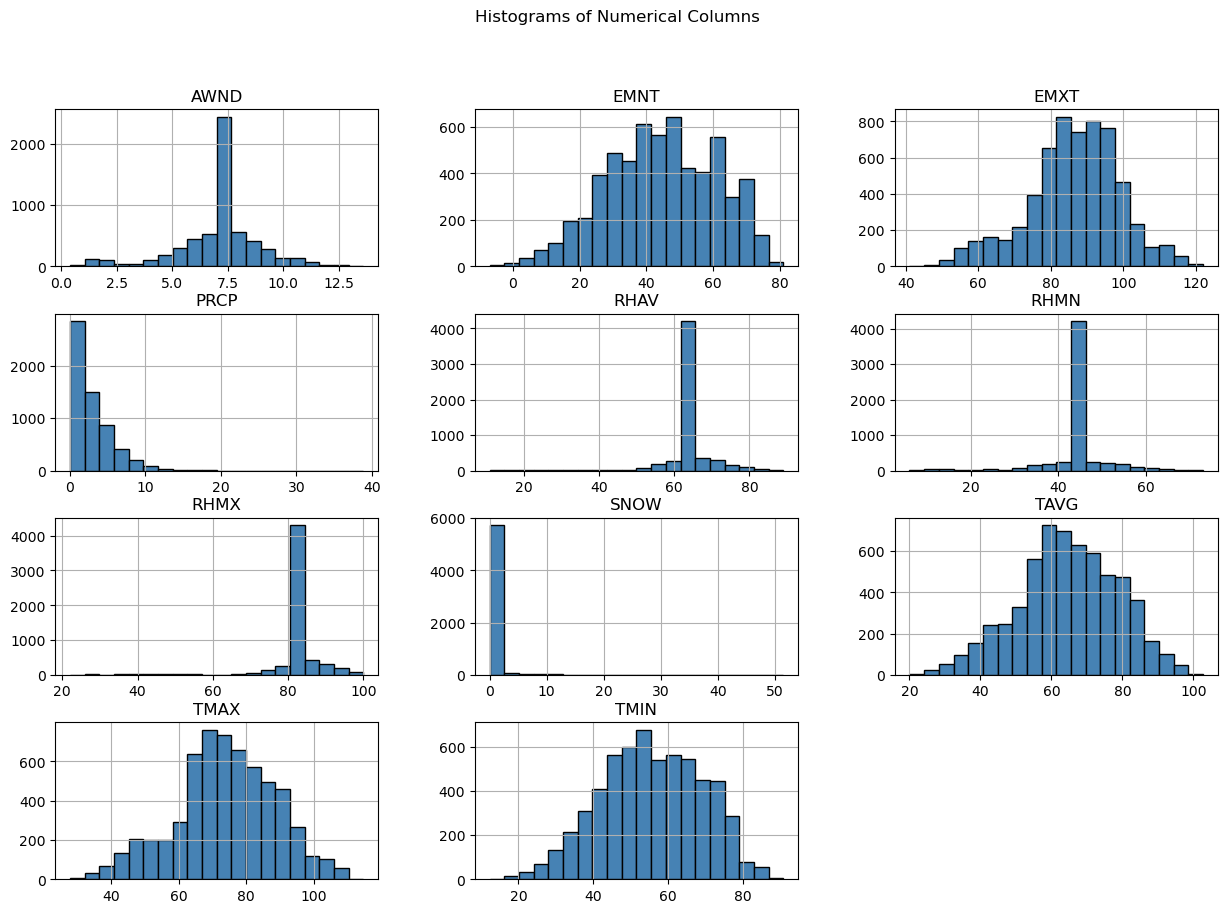

In [22]:
# Histograms for numerical columns
combined_df[numeric_columns].hist(bins=20, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Columns')
plt.show()

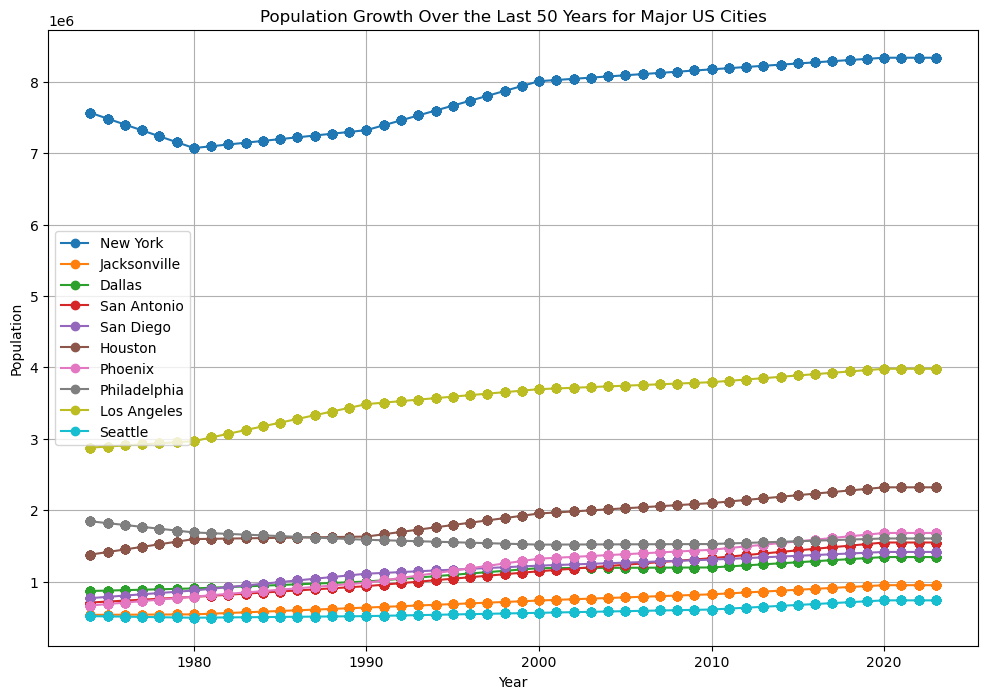

In [23]:
# Plot population growth for each city over the last 50 years
plt.figure(figsize=(12, 8))

for city in cities:
    city_data = combined_df[combined_df['City'] == city]
    plt.plot(city_data['Year'], city_data['Population'], marker='o', label=city)

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population Growth Over the Last 50 Years for Major US Cities')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Time Series Analysis
To dive deeper into the weather patterns, we create time-series plots for each city, focusing on the average temperature (`TAVG`) and precipitation (`PRCP`). These plots help us understand the temporal patterns and seasonal variations in these cities.


In [24]:
# Function to plot time series for a given city
def plot_time_series(city_name, df):
    city_df = df[df['City'] == city_name]
    city_df.set_index('DATE', inplace=True)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=city_df['TAVG'], label='Average Temperature (TAVG)', color='blue')
    sns.lineplot(data=city_df['PRCP'], label='Precipitation (PRCP)', color='orange')
    plt.title(f'Time Series Analysis for {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


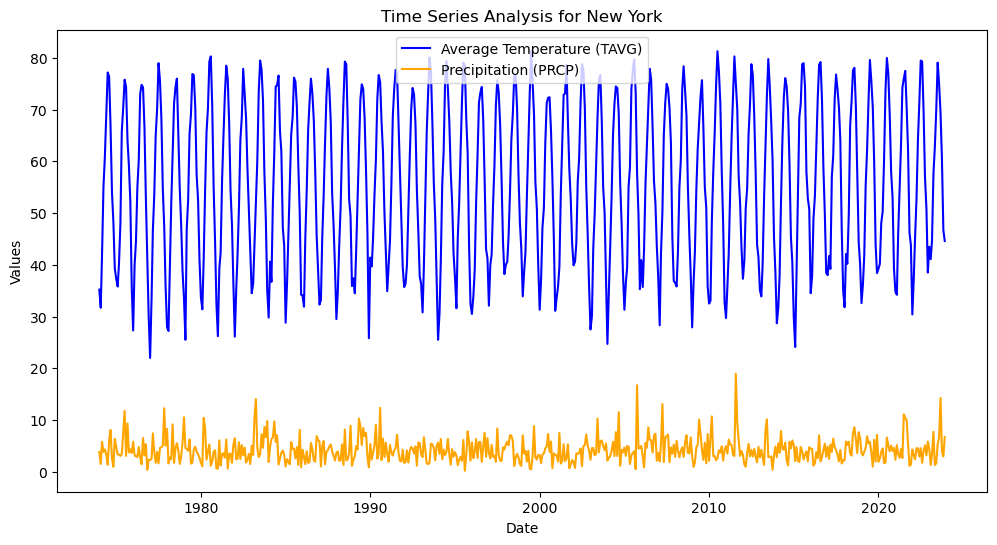

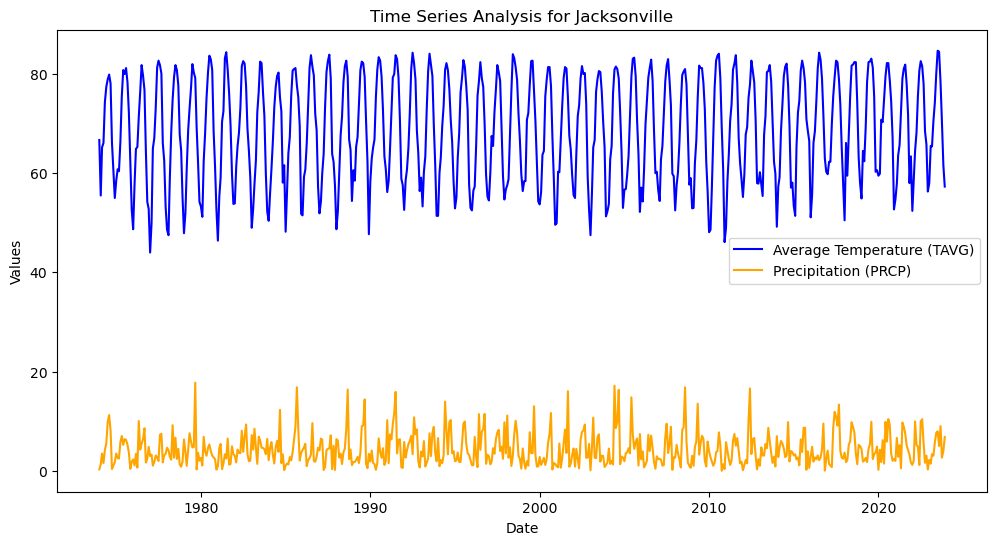

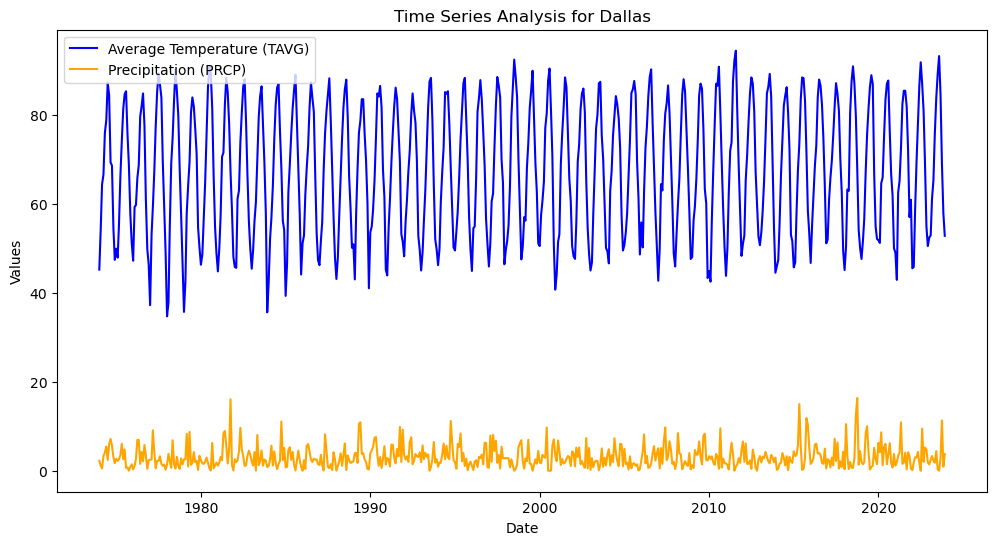

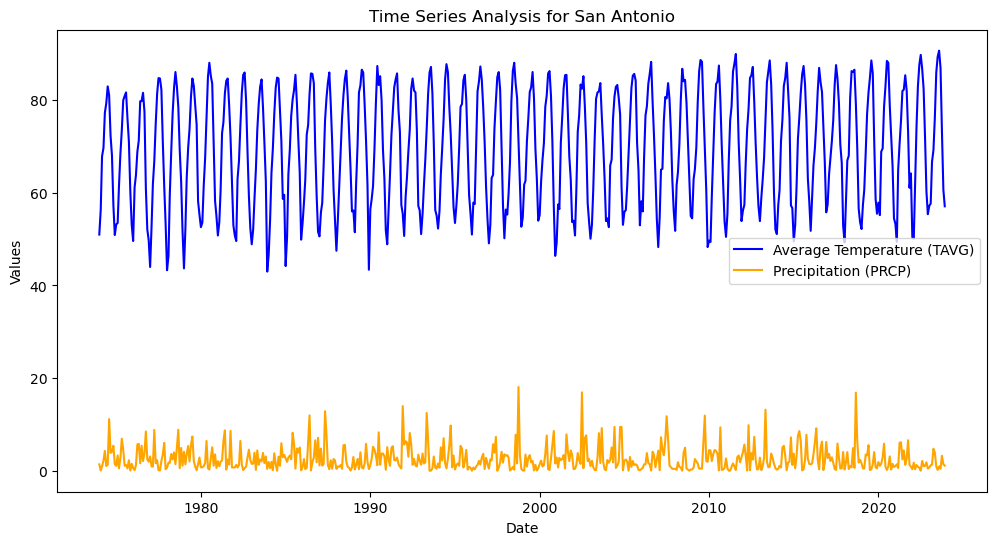

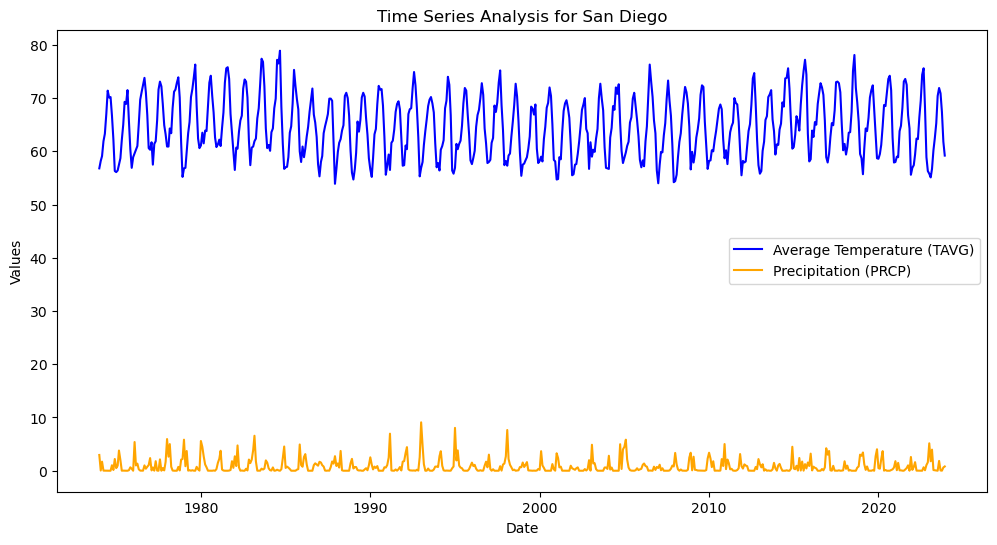

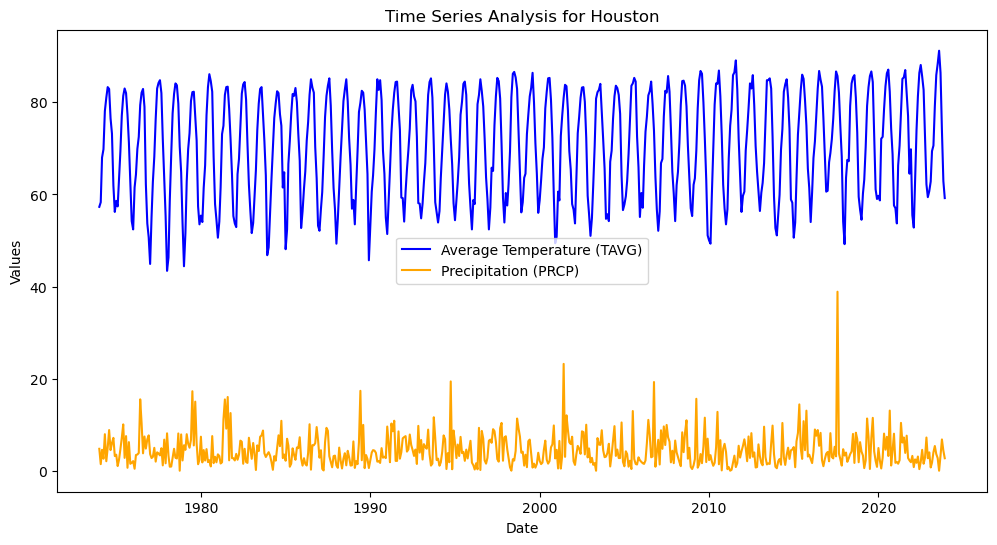

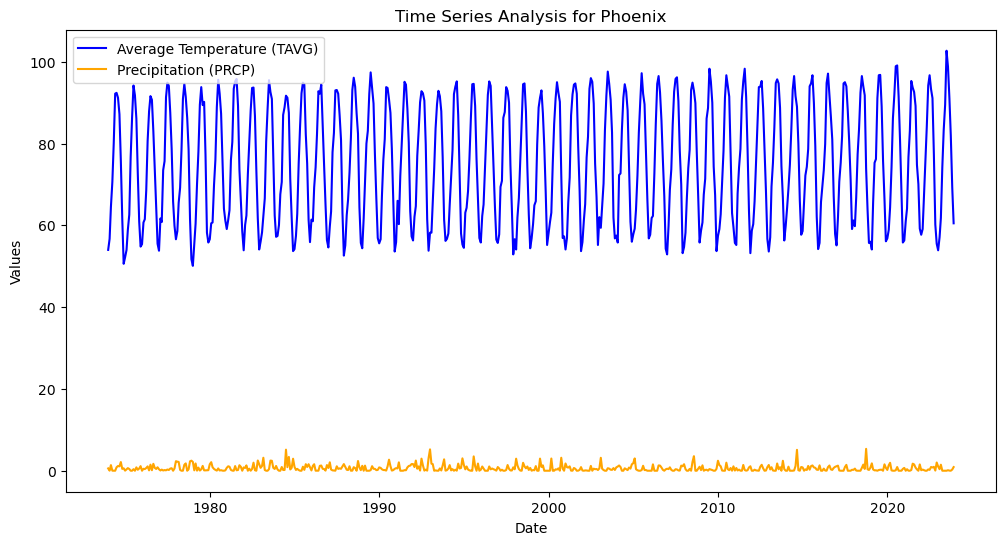

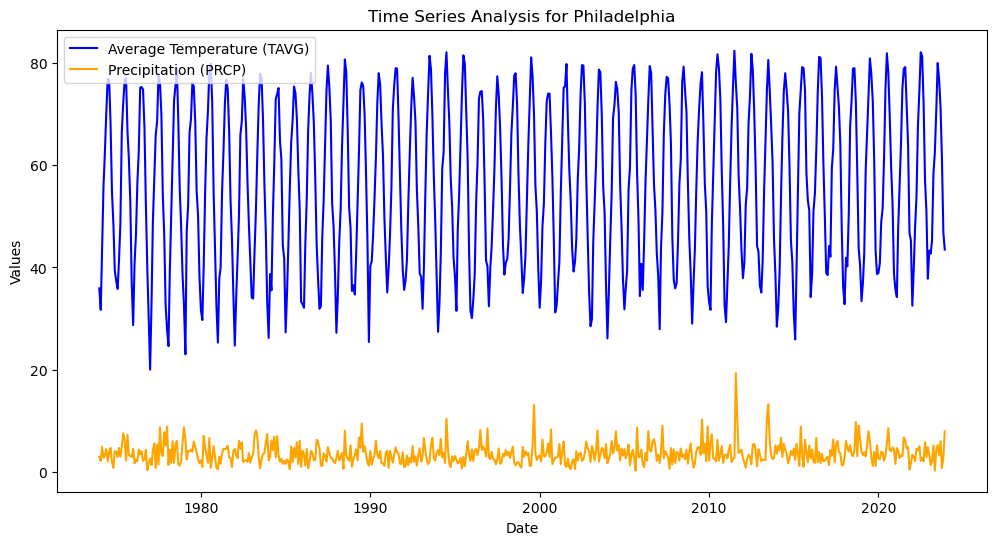

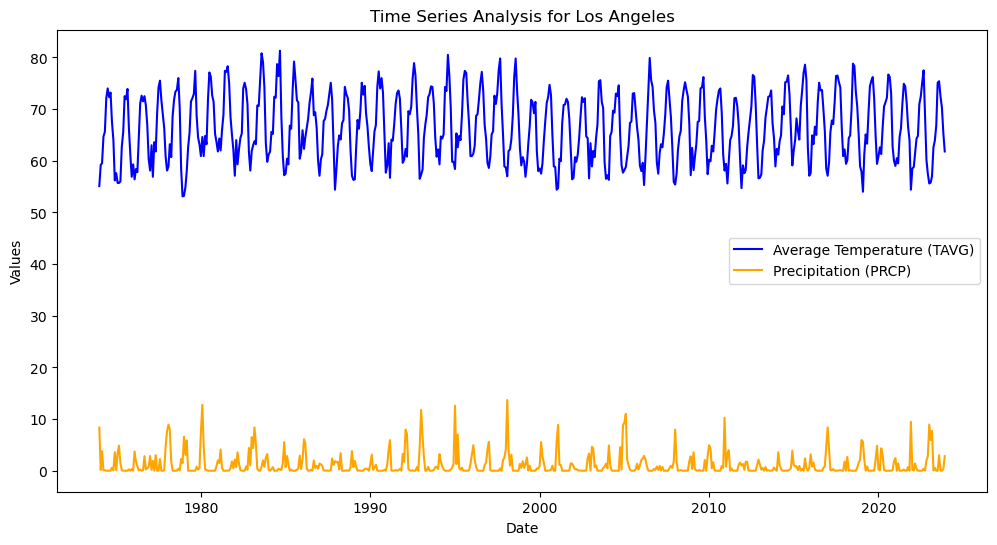

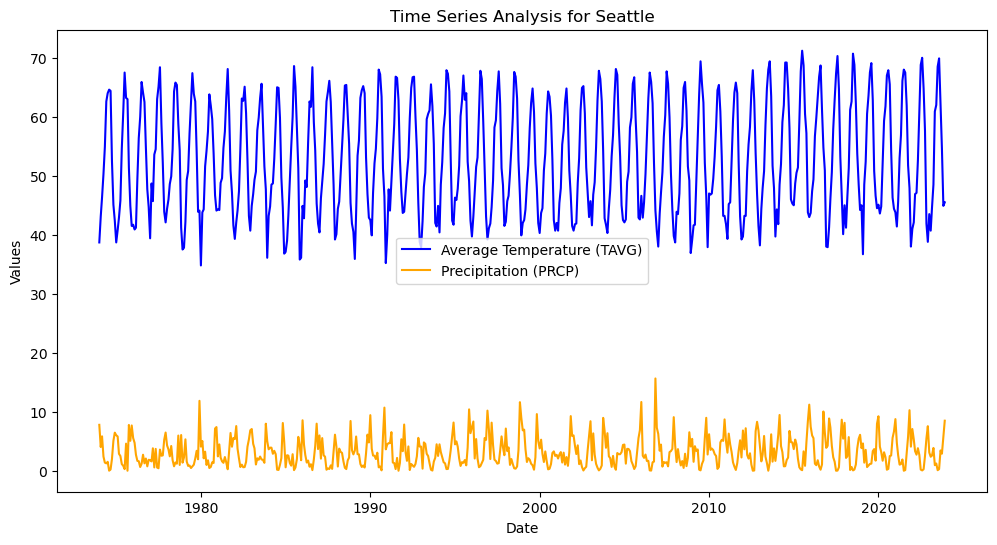

In [25]:
# Plot time series for each city
for city in cities:
    plot_time_series(city, combined_df)

### Correlation Analysis
We further explore the relationships between different weather variables using a correlation matrix heatmap. This visualization highlights the strength and direction of linear relationships between variables, helping us identify potential predictors for further analysis.


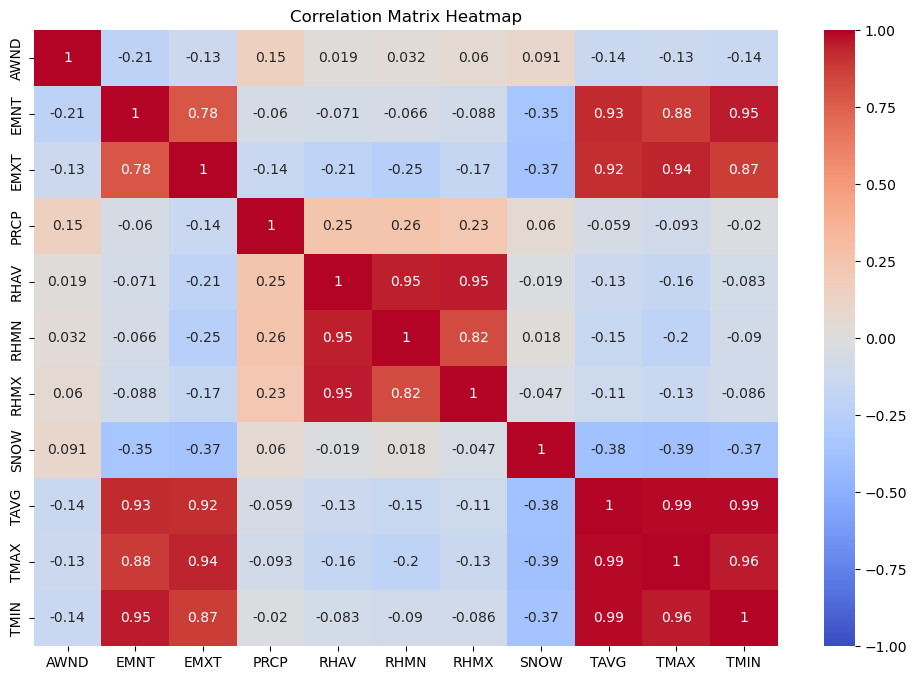

In [26]:
# Correlation matrix heatmap
correlation_matrix = combined_df[numeric_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Comparison of Weather Variables Across Cities
Lastly, we compare selected weather variables across the different cities using boxplots. These boxplots allow us to compare climatic differences between the cities.


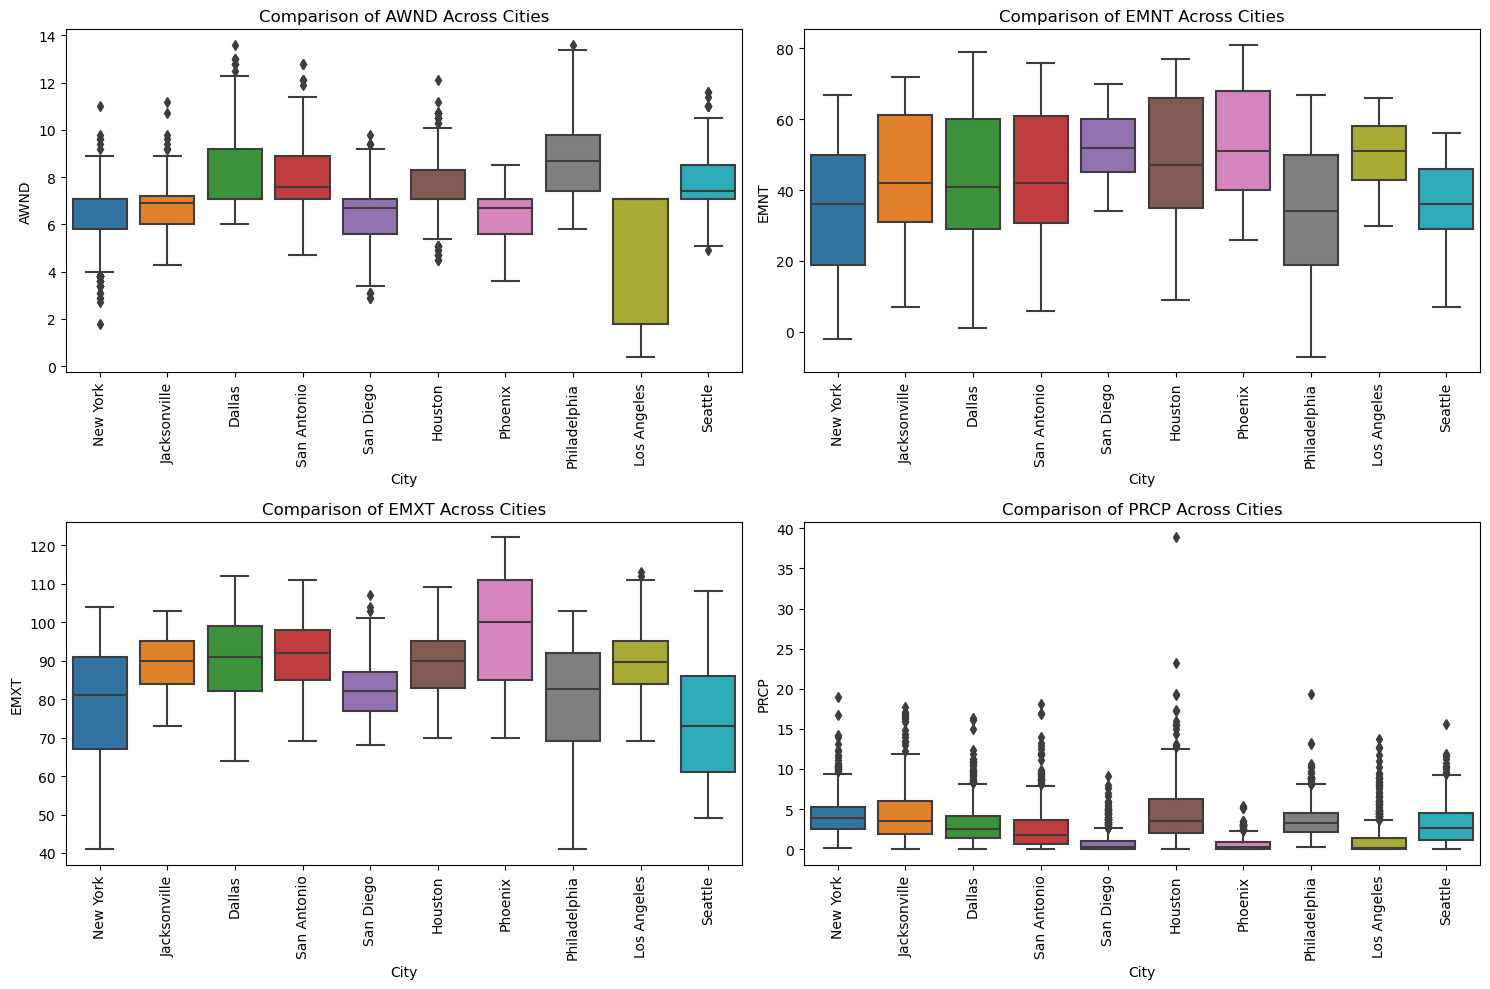

In [27]:
# Boxplots for selected numeric columns across cities
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns[:4]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='City', y=col, data=combined_df)
    plt.title(f'Comparison of {col} Across Cities')
    plt.xticks(rotation=90)
plt.tight_layout()
plt.show()